In [24]:
# some imports
import numpy as np
import torch
import torch.nn as nn
import random
from scipy.ndimage import laplace, sobel
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageFilter
from dataloader import DIV2KDataset
from torchvision import transforms
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from utils.utils_DIP.denoising_utils import *
from models import downsampler
import matplotlib.pyplot as plt


PLOT = True
figsize = 8

In [16]:
class SineLayer(nn.Module):

    """ Linear layer followed by the sine activation

    If `is_first == True`, then it represents the first layer of the network.
    In this case, omega_0 is a frequency factor, which simply multiplies the activations before the nonlinearity.
    Note that it influences the initialization scheme.

    If `is_first == False`, then the weights will be divided by omega_0 so as to keep the magnitude of activations constant,
    but boost gradients to the weight matrix.
    """

    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        # Initialize a linear layer with specified input and output features
        # 'bias' indicates whether to include a bias term
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()

    # initialize weights uniformly
    def init_weights(self):
        # diasble gradient calculation in initialization
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        # Task 1 TODO
        # 1. pass input through linear layer (self.linear layer performs the linear transformation on the input)
        x = self.linear(input)

        # 2. scale the output of the linear transformation by the frequency factor
        x = x * self.omega_0

        # 3. apply sine activation
        x = torch.sin(x)

        return x


In [17]:
class Siren(nn.Module):
    """ SIREN architecture """

    def __init__(self, in_features, out_features, hidden_features=256, hidden_layers=3, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        # add the first layer
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        # append hidden layers
        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))


        if outermost_linear:
            # add a final Linear layer
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad(): # weights intialization
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            # otherwise, add a SineLayer
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net) # sequential wrapper of SineLayer and Linear

    def forward(self, coords):
        # coords represents the 2D pixel coordinates
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

In [18]:
def get_mgrid(sidelen1,sidelen2, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''

    if sidelen1 >= sidelen2:
      # use sidelen1 steps to generate the grid
      tensors = tuple(dim * [torch.linspace(-1, 1, steps = sidelen1)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim = -1)
      # crop it along one axis to fit sidelen2
      minor = int((sidelen1 - sidelen2)/2)
      mgrid = mgrid[:,minor:sidelen2 + minor]

    if sidelen1 < sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps = sidelen2)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim = -1)

      minor = int((sidelen2 - sidelen1)/2)
      mgrid = mgrid[minor:sidelen1 + minor,:]

    # flatten the gird
    mgrid = mgrid.reshape(-1, dim)

    return mgrid

In [19]:
def image_to_tensor(img):
    transform = Compose([
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img


In [20]:
# Image Fitting Dataloader
class ImageData(Dataset):
    def __init__(self, img):
        super().__init__()

        # convert the image to a tensor with transformations
        img = image_to_tensor(img)

        self.pixels = img.permute(1, 2, 0).reshape(-1, 3) # pixel values of the org img

        # create a grid of coordinates for the image
        self.coords = get_mgrid(img.shape[1], img.shape[2], 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

Selected Image Index: 84


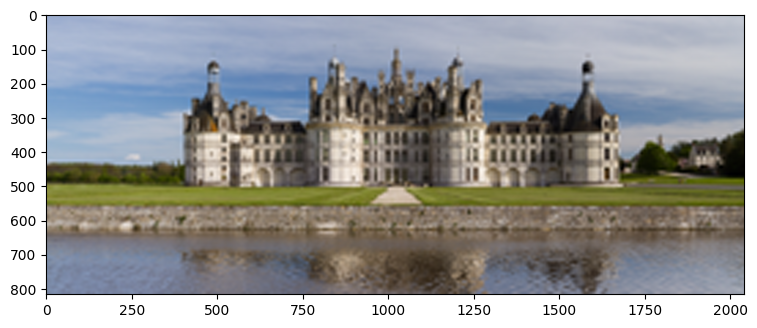

Width: 2040, Height: 816


In [ ]:
# Define transforms (convert to tensor)
tfs = transforms.Compose([
    transforms.ToTensor()
])

# Initialize Dataset
valid_dataset = DIV2KDataset(
    hr_dir="dataset/DIV2K_valid_HR/DIV2K_valid_HR",
    lr_dir="dataset/DIV2K_valid_LR_x8/DIV2K_valid_LR_x8",  # Check your unzipped folder name
    transform=tfs
)

valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

total_images = len(valid_dataset)
# 2. Pick a random index
random_idx = random.randint(0, total_images - 1)

# 3. Retrieve the image pair directly
lr_image, hr_image = valid_dataset[random_idx]


print(f"Selected Image Index: {random_idx}")

lr_image_VR = lr_image

 

# Upsample LR image to match HR size
import torch.nn.functional as F
lr_image = F.interpolate(lr_image.unsqueeze(0), size=hr_image.shape[1:], mode='bicubic', align_corners=False).squeeze(0)

# Convert tensors to numpy arrays
lr_image_np = np.clip(torch_to_np(lr_image.unsqueeze(0)), 0, 1)

if PLOT:
    plot_image_grid([lr_image_np], 4, figsize)




# Get width and height
width, height = lr_image_np.shape[2], lr_image_np.shape[1]
print(f"Width: {width}, Height: {height}")

In [ ]:
# Option 2 cont.
# image = Image.open('yourimage.jpg') # use any image you like

# # Get width and height
# width, height = image.size
# print(f"Width: {width}, Height: {height}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04317506..1.0093608].


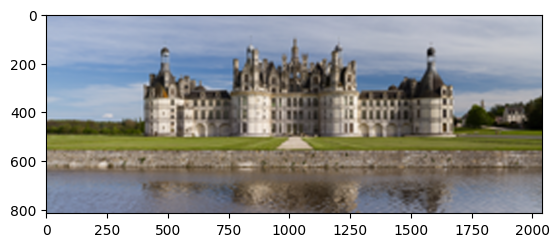

In [34]:
# Task 2 TODO
plt.imshow(lr_image.permute(1,2,0))
plt.pause(0.1)

In [35]:
## Training 

# set the device to 'cuda' if available, otherwise 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# create an ImageData instance
celeb = ImageData(lr_image_np)
dataloader = DataLoader(celeb, batch_size=1, pin_memory=True, num_workers=0)

# initialize a SIREN model
img_siren = Siren(in_features=2, out_features=3, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
img_siren = img_siren.to(device)

In [36]:
# define differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

HR shape: torch.Size([3, 816, 2040]), LR shape: torch.Size([3, 102, 255])
Scale factor: ~8.0x in height, ~8.0x in width


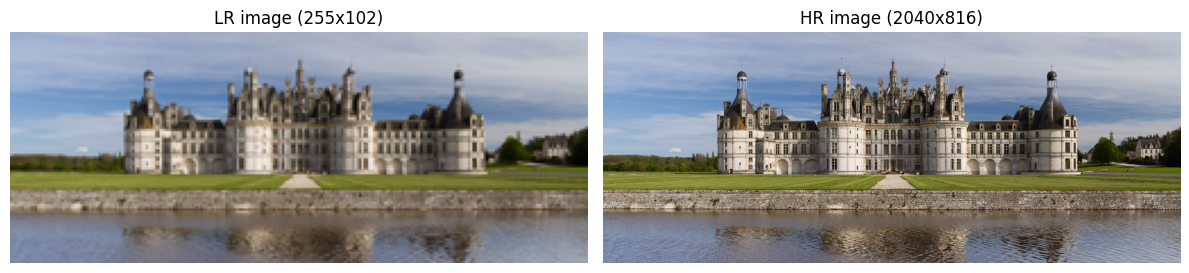

In [41]:
# Prepare LR→HR super-resolution data from DIV2K dataset
# We already have lr_image_VR (low-res) and hr_image (high-res) from the dataset

# Convert to proper tensors in [-1,1] range
hr_tensor = hr_image.to(device)  # [C,H,W], already in [0,1]
hr_tensor = (hr_tensor - 0.5) / 0.5  # normalize to [-1,1]

lr_tensor = lr_image_VR.to(device)  # [C,h_lr,w_lr], already in [0,1]
lr_tensor = (lr_tensor - 0.5) / 0.5  # normalize to [-1,1]

C, H, W = hr_tensor.shape
_, h_lr, w_lr = lr_tensor.shape

print(f"HR shape: {hr_tensor.shape}, LR shape: {lr_tensor.shape}")
print(f"Scale factor: ~{H/h_lr:.1f}x in height, ~{W/w_lr:.1f}x in width")

# Visualize HR and LR images
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title(f'LR image ({w_lr}x{h_lr})')
plt.imshow(lr_tensor.cpu().permute(1,2,0)*0.5+0.5)
plt.axis('off')

plt.subplot(1,2,2)
plt.title(f'HR image ({W}x{H})')
plt.imshow(hr_tensor.cpu().permute(1,2,0)*0.5+0.5)
plt.axis('off')
plt.tight_layout()
plt.show()


In [42]:
# Super-resolution training loop: fit SIREN to map LR→HR
# Strategy: Train on LR coordinates to predict HR pixel values

# Build coordinate grids
lr_coords = get_mgrid(h_lr, w_lr, dim=2).to(device)  # [h_lr*w_lr, 2]
hr_coords = get_mgrid(H, W, dim=2).to(device)        # [H*W, 2]

# Prepare pixel targets
lr_pixels = lr_tensor.permute(1,2,0).reshape(-1, C)  # [h_lr*w_lr, C]
hr_pixels = hr_tensor.permute(1,2,0).reshape(-1, C)  # [H*W, C]

# Initialize SIREN for SR
sr_siren = Siren(in_features=2, out_features=3, hidden_features=256,
                 hidden_layers=3, outermost_linear=True).to(device)

optimizer = torch.optim.Adam(sr_siren.parameters(), lr=1e-4)
criterion = nn.MSELoss()

n_epochs = 5000
print_every = 500

# Training: fit SIREN on LR coords→LR pixels, then evaluate at HR coords
for epoch in range(1, n_epochs+1):
    optimizer.zero_grad()

    # Predict RGB at LR coords (supervise on LR observations)
    pred_lr, _ = sr_siren(lr_coords)
    
    loss = criterion(pred_lr, lr_pixels)
    loss.backward()
    optimizer.step()

    if epoch % print_every == 0 or epoch == 1:
        with torch.no_grad():
            # Also evaluate on HR coords to see SR quality
            pred_hr, _ = sr_siren(hr_coords)
            hr_loss = criterion(pred_hr, hr_pixels)
        print(f"Epoch {epoch}/{n_epochs}, LR Loss: {loss.item():.6f}, HR Loss: {hr_loss.item():.6f}")

print("\nTraining complete!")


Epoch 1/5000, LR Loss: 0.147166, HR Loss: 0.157884
Epoch 500/5000, LR Loss: 0.000472, HR Loss: 0.033927
Epoch 500/5000, LR Loss: 0.000472, HR Loss: 0.033927
Epoch 1000/5000, LR Loss: 0.000078, HR Loss: 0.034021
Epoch 1000/5000, LR Loss: 0.000078, HR Loss: 0.034021
Epoch 1500/5000, LR Loss: 0.000036, HR Loss: 0.034001
Epoch 1500/5000, LR Loss: 0.000036, HR Loss: 0.034001
Epoch 2000/5000, LR Loss: 0.000033, HR Loss: 0.034231
Epoch 2000/5000, LR Loss: 0.000033, HR Loss: 0.034231
Epoch 2500/5000, LR Loss: 0.000030, HR Loss: 0.034140
Epoch 2500/5000, LR Loss: 0.000030, HR Loss: 0.034140
Epoch 3000/5000, LR Loss: 0.000017, HR Loss: 0.034121
Epoch 3000/5000, LR Loss: 0.000017, HR Loss: 0.034121
Epoch 3500/5000, LR Loss: 0.000023, HR Loss: 0.033817
Epoch 3500/5000, LR Loss: 0.000023, HR Loss: 0.033817
Epoch 4000/5000, LR Loss: 0.000073, HR Loss: 0.033969
Epoch 4000/5000, LR Loss: 0.000073, HR Loss: 0.033969
Epoch 4500/5000, LR Loss: 0.000023, HR Loss: 0.034004
Epoch 4500/5000, LR Loss: 0.00002

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.004122734..0.97298795].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0520041..1.0249538].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0520041..1.0249538].


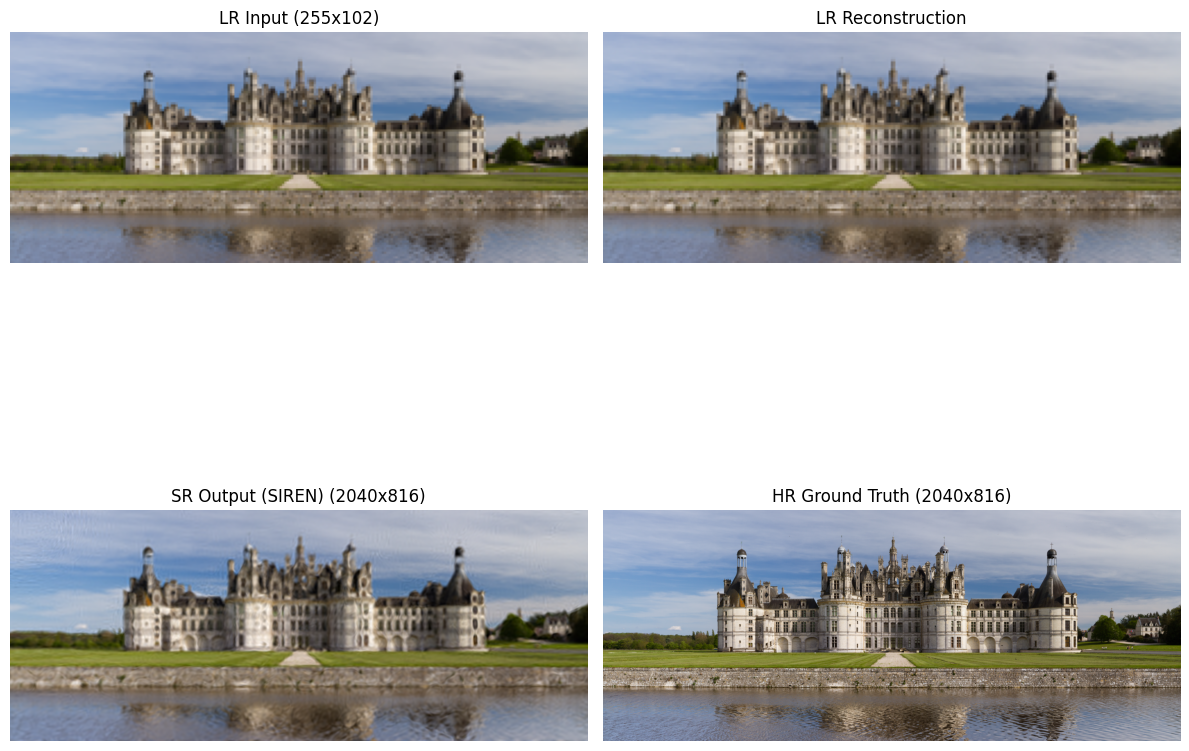


PSNR: 20.70 dB


In [43]:
# Visualize super-resolution results
with torch.no_grad():
    # Generate SR image by evaluating SIREN at HR coordinates
    sr_output, _ = sr_siren(hr_coords)
    sr_image = sr_output.view(H, W, C).cpu()  # [H,W,C]
    sr_image = sr_image * 0.5 + 0.5  # denormalize to [0,1]
    
    # Also get LR prediction for comparison
    lr_pred, _ = sr_siren(lr_coords)
    lr_pred_image = lr_pred.view(h_lr, w_lr, C).cpu()
    lr_pred_image = lr_pred_image * 0.5 + 0.5

# Display results
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(lr_tensor.cpu().permute(1,2,0)*0.5+0.5)
axes[0, 0].set_title(f'LR Input ({w_lr}x{h_lr})')
axes[0, 0].axis('off')

axes[0, 1].imshow(lr_pred_image)
axes[0, 1].set_title('LR Reconstruction')
axes[0, 1].axis('off')

axes[1, 0].imshow(sr_image)
axes[1, 0].set_title(f'SR Output (SIREN) ({W}x{H})')
axes[1, 0].axis('off')

axes[1, 1].imshow(hr_tensor.cpu().permute(1,2,0)*0.5+0.5)
axes[1, 1].set_title(f'HR Ground Truth ({W}x{H})')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Calculate PSNR
mse = torch.mean((sr_image - (hr_tensor.cpu().permute(1,2,0)*0.5+0.5))**2)
psnr = 10 * torch.log10(1.0 / mse)
print(f"\nPSNR: {psnr.item():.2f} dB")
